# Email Spam Classifier


## Import Necessary Libraries

In [234]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

### Load the dataset

In [235]:
df = pd.read_csv('emails.csv', encoding='latin-1')

## Explore the dataset

In [236]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [237]:
df['text'][2200]

'Subject: re : vacation  shirley ,  no problem . please , coordinate with kevin and anita .  vince  shirley crenshaw  09 / 06 / 2000 03 : 30 pm  to : vince j kaminski / hou / ect @ ect  cc :  subject : vacation  vince :  i would like to take next wednesday , the 13 th as a vacation day , if it is  alright . you will not be here .  thanks !  shirley'

In [238]:
df['spam'][2200]

0

In [239]:
df.isnull().sum()

text    0
spam    0
dtype: int64

In [240]:
df.duplicated().sum()

33

In [241]:
# Drop the duplicate values
df.drop_duplicates(inplace=True)

In [242]:
df.duplicated().sum()

0

In [243]:
df['spam'].value_counts()

spam
0    4327
1    1368
Name: count, dtype: int64

#### We have 1368 emails as a spam and 4327 emails as a ham

In [244]:
# Find the total num of characters of each email
df['char_num']=df['text'].apply(lambda x: len(x.strip()))

In [245]:
df.head()

,text,spam,char_num
0,Subject: naturally irresistible your corporate...,1,1484
1,Subject: the stock trading gunslinger fanny i...,1,597
2,Subject: unbelievable new homes made easy im ...,1,448
3,Subject: 4 color printing special request add...,1,499
4,"Subject: do not have money , get software cds ...",1,235


In [246]:
df.sample(10)

,text,spam,char_num
2727,"Subject: re : meeting on feb 8 , 2001 dear mr...",0,1166
1236,"Subject: logo , stationer , website design and...",1,1486
2517,Subject: hello all : please send an email to ...,0,2591
5202,"Subject: re : credit rating contact ? kim , ...",0,704
243,Subject: . . . if you ' re looking for the low...,1,253
125,"Subject: our cool medz hello , welcome to med...",1,494
3440,"Subject: re : i would like to help , but i am...",0,926
1873,Subject: re : conversation w / andersen vince...,0,5081
4877,Subject: organization announcement enron purc...,0,2331
4026,Subject: west power model lance and i spoke w...,0,712


## EDA

/var/folders/tz/x4nyk_3177g_wk1rwy7nsjcm0000gn/T/ipykernel_8134/2689356547.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Ham','Spam'])


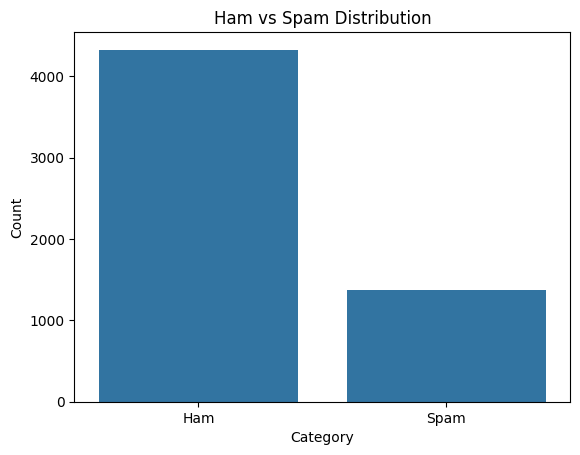

In [247]:
counts=df['spam'].value_counts()
ax=sns.barplot(counts)
ax.set_xticklabels(['Ham','Spam'])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Ham vs Spam Distribution')
plt.show()

## 

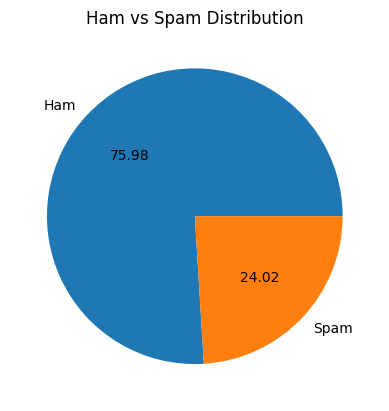

In [248]:
plt.pie(df['spam'].value_counts(),labels=(['Ham','Spam']),autopct="%0.2f")
plt.title('Ham vs Spam Distribution')
plt.show()

### Here we can clearly see that the data are imbalance

<Axes: xlabel='char_num', ylabel='Count'>

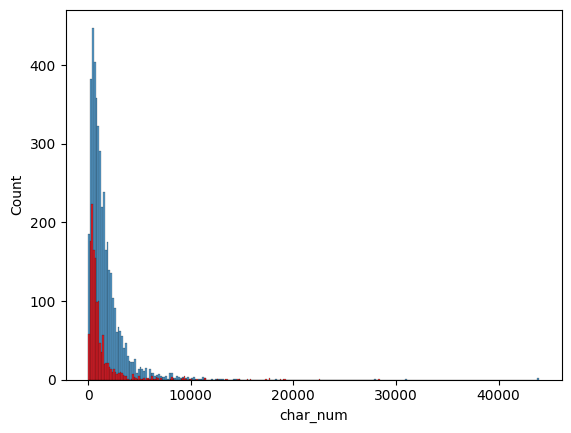

In [249]:
sns.histplot(df[df['spam']==0]['char_num'])
sns.histplot(df[df['spam']==1]['char_num'],color='r')

In [250]:
from nltk import word_tokenize

In [251]:
df['words_num']=df['text'].apply(lambda x: len(word_tokenize(x)))

In [252]:
df.head()

,text,spam,char_num,words_num
0,Subject: naturally irresistible your corporate...,1,1484,325
1,Subject: the stock trading gunslinger fanny i...,1,597,90
2,Subject: unbelievable new homes made easy im ...,1,448,88
3,Subject: 4 color printing special request add...,1,499,99
4,"Subject: do not have money , get software cds ...",1,235,53


<Axes: xlabel='words_num', ylabel='Count'>

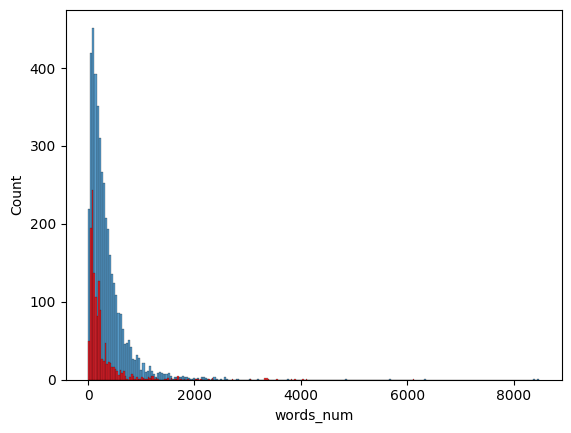

In [253]:
sns.histplot(df[df['spam']==0]['words_num'])
sns.histplot(df[df['spam']==1]['words_num'],color='r')

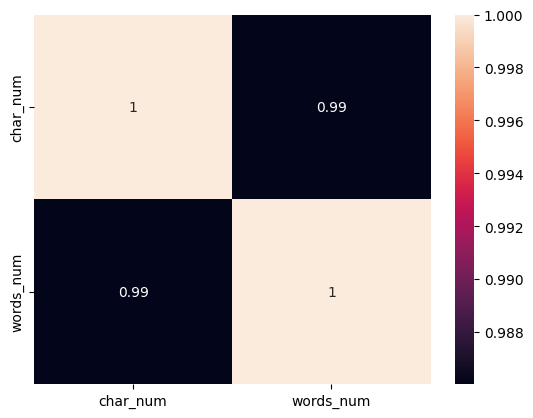

In [254]:
sns.heatmap(df[['char_num','words_num']].corr(),annot=True)
plt.show()

### Correlation between two new added features are very high so we will be using only one feature if needed 

## Preprocessing

In [258]:
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

def text_preprocessing(text):
    text = text.lower()
    
    text = BeautifulSoup(text, "html.parser").get_text() # remove html related words
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'_+', ' ', text)  # remove repeated underscores
    text = re.sub(r'\b\d+\b', ' <NUM> ', text)
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)

    custom_stopwords = {'_', 'subject', 'com', 'http', 'mail', 'e', 'u', '000', 'www','NUM','enron','ect' ,'vince' ,'hou', 'kaminski', 'cc'} # These are the repeated words which doesn't make sense for me so im manually removing these words
    stop_words = set(stopwords.words('english')).union(custom_stopwords)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    tagged_tokens = pos_tag(tokens)

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]

    return " ".join(tokens)



### I tried using both PorterStemmer and Lemmatizer. But i got little bit good accuracy using Lemmatizer so I'm using Lemmatization for this project.

In [259]:
df['Processed_text']=df['text'].apply(text_preprocessing)

In [260]:
df['Processed_text'][0]

'naturally irresistible corporate identity lt really hard recollect company market full suqgestions information isoverwhelminq good catchy logo stylish statlonery outstanding website make task much easy promise havinq order iogo company automaticaily become world ieader isguite ciear without good product effective business organization practicable aim hotat nowadays market promise marketing effort become much effective list clear benefit creativeness hand make original logo specially do reflect distinctive company image convenience logo stationery provide format easy use content management system letsyou change website content even structure promptness see logo draft within three business day affordability marketing break make gap budget satisfaction guarantee provide unlimited amount change extra fee surethat love result collaboration look portfolio interested'

In [261]:
df.head()

,text,spam,char_num,words_num,Processed_text
0,Subject: naturally irresistible your corporate...,1,1484,325,naturally irresistible corporate identity lt r...
1,Subject: the stock trading gunslinger fanny i...,1,597,90,stock trading gunslinger fanny merrill muzo co...
2,Subject: unbelievable new homes made easy im ...,1,448,88,unbelievable new home make easy im want show h...
3,Subject: 4 color printing special request add...,1,499,99,color print special request additional informa...
4,"Subject: do not have money , get software cds ...",1,235,53,money get software cd software compatibility g...


In [262]:
from wordcloud import WordCloud
wc=WordCloud(height= 400)

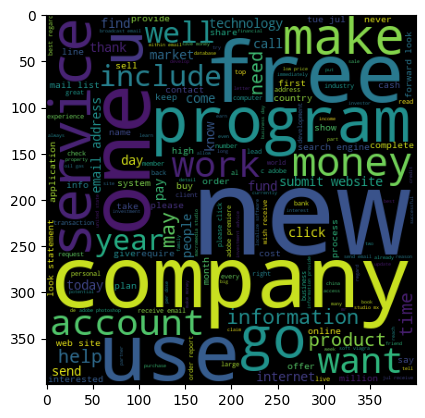

In [263]:
# Spam Word Cloud
spam_wc=wc.generate(df[df['spam']==1]['Processed_text'].str.cat(sep=" "))
plt.imshow(spam_wc)

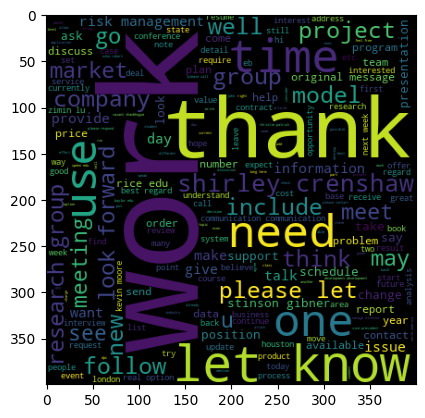

In [264]:
# ham Word Cloud
ham_wc=wc.generate(df[df['spam']==0]['Processed_text'].str.cat(sep=" "))
plt.imshow(ham_wc)

## Most Common Spam words

In [265]:
all_spam_words=[]
for i in df[df['spam']==1]['Processed_text'].tolist():
    for word in i.split():
        all_spam_words.append(word)


In [266]:
len(all_spam_words)

152759

In [267]:
from collections import Counter 

Counter(all_spam_words).most_common(50)

[('company', 1064),
 ('business', 891),
 ('email', 860),
 ('make', 839),
 ('get', 754),
 ('information', 748),
 ('receive', 714),
 ('money', 662),
 ('free', 607),
 ('please', 606),
 ('one', 592),
 ('time', 591),
 ('click', 550),
 ('order', 539),
 ('u', 537),
 ('use', 528),
 ('send', 528),
 ('offer', 508),
 ('new', 507),
 ('report', 496),
 ('price', 491),
 ('list', 490),
 ('may', 489),
 ('website', 483),
 ('adobe', 462),
 ('address', 460),
 ('security', 443),
 ('message', 442),
 ('software', 440),
 ('need', 433),
 ('day', 420),
 ('want', 417),
 ('provide', 413),
 ('work', 411),
 ('account', 402),
 ('look', 396),
 ('service', 395),
 ('site', 374),
 ('year', 366),
 ('see', 359),
 ('people', 358),
 ('best', 357),
 ('program', 357),
 ('like', 355),
 ('take', 354),
 ('market', 353),
 ('investment', 350),
 ('within', 346),
 ('online', 345),
 ('stock', 340)]

## Most Common ham words

In [268]:
all_ham_words=[]
for i in df[df['spam']==0]['Processed_text'].tolist():
    for word in i.split():
        all_ham_words.append(word)
len(all_ham_words)


554970

In [270]:
from collections import Counter 
Counter(all_ham_words).most_common(30)

[('please', 4398),
 ('would', 4124),
 ('pm', 3247),
 ('forward', 2849),
 ('research', 2655),
 ('time', 2487),
 ('thanks', 2471),
 ('group', 2433),
 ('know', 2367),
 ('work', 2247),
 ('energy', 2108),
 ('risk', 2092),
 ('model', 2088),
 ('market', 1976),
 ('get', 1962),
 ('may', 1955),
 ('power', 1932),
 ('need', 1870),
 ('regard', 1845),
 ('let', 1844),
 ('price', 1820),
 ('send', 1810),
 ('like', 1794),
 ('new', 1773),
 ('shirley', 1674),
 ('corp', 1642),
 ('make', 1641),
 ('also', 1593),
 ('look', 1591),
 ('use', 1590)]

## Vectorizerization

In [271]:
from sklearn.feature_extraction.text import TfidfVectorizer
tff=TfidfVectorizer()

### I tried using CounerVectorizer but it didn't give good metrices. So im using  Tfidf Vectorizer

In [272]:
x=tff.fit_transform(df['Processed_text'])


In [273]:
print(f"Total length of Vocabulary: {len(tff.vocabulary_)}")
print(f"Shape of x: {x.shape}")
print(x)

Total length of Vocabulary: 29774
Shape of x: (5695, 29774)
  (0, 17515)	0.11919293119322424
  (0, 13341)	0.13935885865753334
  (0, 5614)	0.0721704869881379
  (0, 12327)	0.08963715383126493
  (0, 15475)	0.10949068855000824
  (0, 21646)	0.06635752358260898
  (0, 11399)	0.07514541570054235
  (0, 21750)	0.11077552279366805
  (0, 4986)	0.15384730003489597
  (0, 15948)	0.10239278367360924
  (0, 10277)	0.0651168421513792
  (0, 25575)	0.12031185672286512
  (0, 12822)	0.043784721725525465
  (0, 13386)	0.13121025143013954
  (0, 10875)	0.09666963294427582
  (0, 3902)	0.11145550517418128
  (0, 15306)	0.3418241923047106
  (0, 25340)	0.12031185672286512
  (0, 25040)	0.11919293119322424
  (0, 18874)	0.08944124973206402
  (0, 28647)	0.1313036744531574
  (0, 15750)	0.12364323214304737
  (0, 25956)	0.0900357306564284
  (0, 17203)	0.10946081450011472
  (0, 7855)	0.14703259981484534
  :	:
  (5694, 8149)	0.042861484767967466
  (5694, 5871)	0.06480674799787138
  (5694, 7967)	0.04809586080345669
  (5694, 76

In [274]:
df.head()

,text,spam,char_num,words_num,Processed_text
0,Subject: naturally irresistible your corporate...,1,1484,325,naturally irresistible corporate identity lt r...
1,Subject: the stock trading gunslinger fanny i...,1,597,90,stock trading gunslinger fanny merrill muzo co...
2,Subject: unbelievable new homes made easy im ...,1,448,88,unbelievable new home make easy im want show h...
3,Subject: 4 color printing special request add...,1,499,99,color print special request additional informa...
4,"Subject: do not have money , get software cds ...",1,235,53,money get software cd software compatibility g...


## Target

In [275]:
y=df['spam']

In [276]:
y


0       1
1       1
2       1
3       1
4       1
       ..
5723    0
5724    0
5725    0
5726    0
5727    0
Name: spam, Length: 5695, dtype: int64

## Combine the features and split into train and test


In [277]:
from scipy.sparse import hstack, csr_matrix
X_text = x                       
X_word_count = csr_matrix(df[['words_num']].values)

combined_features = hstack([X_text, X_word_count])

# Train test split withe combined features 
from sklearn.model_selection import train_test_split

X_train_combine, X_test_combine, y_train_combine, y_test_cmobine = train_test_split(
    combined_features, y, test_size=0.2, random_state=42, stratify=y
)


## Train test split for single feature

In [278]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(x,y,random_state=42,test_size=0.2)

In [279]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4556, 29774), (1139, 29774), (4556,), (1139,))

## Trining with combined features

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


from xgboost import XGBClassifier

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(
    bootstrap=False,n_estimators=500,class_weight="balanced",max_features='log2',min_samples_split=10,random_state=42
    ),
    "SVM": svm.SVC(kernel='sigmoid',gamma='scale',class_weight="balanced",C=1),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_combine, y_train_combine)
    y_pred = model.predict(X_test_combine)
    
    acc = accuracy_score(y_test_cmobine, y_pred)
    prec = precision_score(y_test_cmobine, y_pred, pos_label=1)
    recall = recall_score(y_test_cmobine, y_pred, pos_label=1)
    f1 = f1_score(y_test_cmobine, y_pred, pos_label=1)
    cm = confusion_matrix(y_test_cmobine, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": cm
    })

results_df = pd.DataFrame(results)[["Model", "Accuracy", "Precision", "Recall", "F1 Score"]]
print("📊 Comparison Between Classification Models With Combined Features:")
print(results_df.sort_values("F1 Score", ascending=False).reset_index(drop=True))

📊 Comparison Between Classification Models With Combined Features:
                 Model  Accuracy  Precision    Recall  F1 Score
0              XGBoost  0.973661   0.962121  0.927007  0.944238
1        Random Forest  0.974539   1.000000  0.894161  0.944123
2  Logistic Regression  0.969271   0.991770  0.879562  0.932302
3             AdaBoost  0.948200   0.931727  0.846715  0.887189
4        Decision Tree  0.935031   0.847222  0.890511  0.868327
5  K-Nearest Neighbors  0.820018   0.748201  0.379562  0.503632
6          Naive Bayes  0.829675   1.000000  0.291971  0.451977
7                  SVM  0.520632   0.252727  0.507299  0.337379


### Here we can see the model performance with combined features are not good. So let's do again with single feature.

In [304]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


from xgboost import XGBClassifier

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(
    bootstrap=False,n_estimators=500,class_weight="balanced",max_features='log2',min_samples_split=10,random_state=42
    ),
    "SVM": svm.SVC(kernel='sigmoid',gamma='scale',class_weight="balanced",C=1, probability=True),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": cm
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)[["Model", "Accuracy", "Precision", "Recall", "F1 Score"]]
print("📊 Comparison Between Classification Models:")
print(results_df.sort_values("F1 Score", ascending=False).reset_index(drop=True))


📊 Comparison Between Classification Models:
                 Model  Accuracy  Precision    Recall  F1 Score
0                  SVM  0.992976   0.989796  0.983108  0.986441
1  K-Nearest Neighbors  0.973661   0.981884  0.915541  0.947552
2              XGBoost  0.969271   0.978022  0.902027  0.938489
3        Random Forest  0.968393   0.996183  0.881757  0.935484
4  Logistic Regression  0.959614   0.992126  0.851351  0.916364
5        Decision Tree  0.928007   0.859060  0.864865  0.861953
6             AdaBoost  0.926251   0.952991  0.753378  0.841509
7          Naive Bayes  0.881475   1.000000  0.543919  0.704595


### SVM performed well. So i'm selecting SVM model for further use.

## Save the model using joblib

In [305]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib 

pipeline=Pipeline([
    ('tfidf', tff),
    ('svm',models['SVM'])

])
joblib.dump(pipeline,'pipeline.pkl')

['pipeline.pkl']

## Manual Testing

In [307]:

import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

def text_preprocessing_test(text):
    text = text.lower()
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'_+', ' ', text)  # remove repeated underscores
    text = re.sub(r'\b\d+\b', ' <NUM> ', text)
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)

    custom_stopwords = {'_', 'subject', 'com', 'http', 'mail', 'e', 'u', '000', 'www','NUM'}
    stop_words = set(stopwords.words('english')).union(custom_stopwords)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    tagged_tokens = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]

    return " ".join(tokens)






In [308]:
pipeline = joblib.load('pipeline.pkl')


with open('test.text','r') as f:
    email=f.read()
final_text=text_preprocessing_test(email)


prediction = pipeline.predict([email])
print("Prediction:", "Spam" if prediction[0] == 1 else "Not Spam")

Prediction: Not Spam
